In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import optuna
from dotenv import load_dotenv, find_dotenv
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, mean_absolute_error

KeyboardInterrupt: 

## CARREGANDO CONSTANTES DO AMBIENTE

In [ ]:
load_dotenv(find_dotenv())
CSV = os.getenv("CSV_PATH")

## Carregando dados

In [ ]:
df_vendas = pd.read_csv(f'{CSV}vendas.csv', sep=',', encoding='utf-8')
df_clientes = pd.read_csv(f'{CSV}cliente.csv', sep=',', encoding='utf-8')

In [ ]:
df_vendas

,nk_ota_localizer_id,fk_contact,date_purchase,time_purchase,place_origin_departure,place_destination_departure,place_origin_return,place_destination_return,fk_departure_ota_bus_company,fk_return_ota_bus_company,gmv_success,total_tickets_quantity_success,ano
0,aa34ed7fd0a6b405df2df1bf9f8d68e6df9b9a868a6181...,Cliente 5,2021-02-23,20:08:25,Rodoviária 3,Rodoviária 5,0,0,48449a14a4ff7d79bb7a1b6f3d488eba397c36ef25634c...,1,45.31,1,2021
1,948356b25b90c0c87c147cead27483c481edda1dacc4c8...,Cliente 6,2021-02-11,22:25:15,Rodoviária 5,Rodoviária 6,0,0,1dfacb2ea5a03e0a915999e03b5a56196f1b1664d2f768...,1,154.20,1,2021
2,2ee9d0978acb5e113d0b3f846ab3f88c5a426321da8f87...,Cliente 7,2021-02-19,19:11:40,Rodoviária 6,Rodoviária 7,0,0,1d0ebea552eb43d0b1e1561f6de8ae92e3de7f1abec523...,1,188.99,1,2021
3,929cd361c225ec5d3510e14e8582fdcc61a24383cdb7a7...,Cliente 10,2021-07-02,11:41:19,Rodoviária 8,Rodoviária 10,0,0,c6f3ac57944a531490cd39902d0f777715fd005efac9a3...,1,61.55,1,2021
4,f08c3f551a19f1ce13525825dbf0d0ce9c3492da92bbb2...,Cliente 11,2022-07-14,10:16:52,Rodoviária 9,Rodoviária 11,0,0,96061e92f58e4bdcdee73df36183fe3ac64747c81c26f6...,1,55.46,1,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133305,52a39652c7b3db7eedbba20c16b4e68df6f514bec1ad79...,Cliente 133072,2023-04-21,13:24:41,Rodoviária 1,Rodoviária 80,0,0,35135aaa6cc23891b40cb3f378c53a17a1127210ce60e1...,1,135.23,1,2023
1133306,655038f142aea0104f73671352b3304617b8d19801495a...,Cliente 131770,2023-04-08,10:49:02,Rodoviária 6,Rodoviária 18,0,0,f32828acecb4282c87eaa554d2e1db74e418cd68458430...,1,183.92,1,2023
1133307,4e4f5fcded3e8b6915e05c6b9b504ec6830f723a831f68...,Cliente 133024,2023-12-29,19:47:12,Rodoviária 6,Rodoviária 18,0,0,3068430da9e4b7a674184035643d9e19af3dc7483e31cc...,1,156.00,1,2023
1133308,18b75368642c6c347fd00f56cd98322bb6d920b6a07545...,Cliente 133024,2023-01-08,23:57:55,Rodoviária 6,Rodoviária 18,0,0,35135aaa6cc23891b40cb3f378c53a17a1127210ce60e1...,1,294.99,1,2023


In [ ]:
df_clientes

,fk_contact,total_gasto,qtd_compras,tp_pessoa,ultima_compra,grupo,ticket_medio
0,Cliente 5,85.92,2,PF,2021-02-27,Pessoa - Dormindo,42.96
1,Cliente 6,576.64,3,PF,2021-07-02,Pessoa - Dormindo,192.21
2,Cliente 7,750.89,5,PF,2021-09-03,Pessoa - Dormindo,150.18
3,Cliente 10,1052.88,8,PF,2022-02-15,Pessoa - Quase dormindo,131.61
4,Cliente 11,787.83,16,PF,2022-07-14,Pessoa - Quase dormindo,49.24
...,...,...,...,...,...,...,...
375585,Cliente 581808,569.57,1,PF,2022-02-26,Pessoa - Quase dormindo,569.57
375586,Cliente 581809,76.78,1,PF,2023-10-12,Pessoa - Potencial,76.78
375587,Cliente 581811,82.48,1,PF,2022-12-18,Pessoa - Quase dormindo,82.48
375588,Cliente 581812,119.82,1,PF,2022-02-10,Pessoa - Dormindo,119.82


## Criando um df para treinamento e fazer o predict

In [ ]:
df_vendas

,nk_ota_localizer_id,fk_contact,date_purchase,time_purchase,place_origin_departure,place_destination_departure,place_origin_return,place_destination_return,fk_departure_ota_bus_company,fk_return_ota_bus_company,gmv_success,total_tickets_quantity_success,ano
0,aa34ed7fd0a6b405df2df1bf9f8d68e6df9b9a868a6181...,Cliente 5,2021-02-23,20:08:25,Rodoviária 3,Rodoviária 5,0,0,48449a14a4ff7d79bb7a1b6f3d488eba397c36ef25634c...,1,45.31,1,2021
1,948356b25b90c0c87c147cead27483c481edda1dacc4c8...,Cliente 6,2021-02-11,22:25:15,Rodoviária 5,Rodoviária 6,0,0,1dfacb2ea5a03e0a915999e03b5a56196f1b1664d2f768...,1,154.20,1,2021
2,2ee9d0978acb5e113d0b3f846ab3f88c5a426321da8f87...,Cliente 7,2021-02-19,19:11:40,Rodoviária 6,Rodoviária 7,0,0,1d0ebea552eb43d0b1e1561f6de8ae92e3de7f1abec523...,1,188.99,1,2021
3,929cd361c225ec5d3510e14e8582fdcc61a24383cdb7a7...,Cliente 10,2021-07-02,11:41:19,Rodoviária 8,Rodoviária 10,0,0,c6f3ac57944a531490cd39902d0f777715fd005efac9a3...,1,61.55,1,2021
4,f08c3f551a19f1ce13525825dbf0d0ce9c3492da92bbb2...,Cliente 11,2022-07-14,10:16:52,Rodoviária 9,Rodoviária 11,0,0,96061e92f58e4bdcdee73df36183fe3ac64747c81c26f6...,1,55.46,1,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133305,52a39652c7b3db7eedbba20c16b4e68df6f514bec1ad79...,Cliente 133072,2023-04-21,13:24:41,Rodoviária 1,Rodoviária 80,0,0,35135aaa6cc23891b40cb3f378c53a17a1127210ce60e1...,1,135.23,1,2023
1133306,655038f142aea0104f73671352b3304617b8d19801495a...,Cliente 131770,2023-04-08,10:49:02,Rodoviária 6,Rodoviária 18,0,0,f32828acecb4282c87eaa554d2e1db74e418cd68458430...,1,183.92,1,2023
1133307,4e4f5fcded3e8b6915e05c6b9b504ec6830f723a831f68...,Cliente 133024,2023-12-29,19:47:12,Rodoviária 6,Rodoviária 18,0,0,3068430da9e4b7a674184035643d9e19af3dc7483e31cc...,1,156.00,1,2023
1133308,18b75368642c6c347fd00f56cd98322bb6d920b6a07545...,Cliente 133024,2023-01-08,23:57:55,Rodoviária 6,Rodoviária 18,0,0,35135aaa6cc23891b40cb3f378c53a17a1127210ce60e1...,1,294.99,1,2023


In [ ]:
df_predict = df_vendas.drop(columns=['nk_ota_localizer_id','fk_departure_ota_bus_company', 'fk_return_ota_bus_company', 'ano'])
df_predict

,fk_contact,date_purchase,time_purchase,place_origin_departure,place_destination_departure,place_origin_return,place_destination_return,gmv_success,total_tickets_quantity_success
0,Cliente 5,2021-02-23,20:08:25,Rodoviária 3,Rodoviária 5,0,0,45.31,1
1,Cliente 6,2021-02-11,22:25:15,Rodoviária 5,Rodoviária 6,0,0,154.20,1
2,Cliente 7,2021-02-19,19:11:40,Rodoviária 6,Rodoviária 7,0,0,188.99,1
3,Cliente 10,2021-07-02,11:41:19,Rodoviária 8,Rodoviária 10,0,0,61.55,1
4,Cliente 11,2022-07-14,10:16:52,Rodoviária 9,Rodoviária 11,0,0,55.46,1
...,...,...,...,...,...,...,...,...,...
1133305,Cliente 133072,2023-04-21,13:24:41,Rodoviária 1,Rodoviária 80,0,0,135.23,1
1133306,Cliente 131770,2023-04-08,10:49:02,Rodoviária 6,Rodoviária 18,0,0,183.92,1
1133307,Cliente 133024,2023-12-29,19:47:12,Rodoviária 6,Rodoviária 18,0,0,156.00,1
1133308,Cliente 133024,2023-01-08,23:57:55,Rodoviária 6,Rodoviária 18,0,0,294.99,1


In [ ]:
df_predict['datetime'] = pd.to_datetime(df_predict['date_purchase'] + ' ' + df_predict['time_purchase'])
df_predict = df_predict.sort_values(by=['fk_contact', 'datetime']).reset_index(drop=True)
df_predict = df_predict.drop(columns=['date_purchase', 'time_purchase'])
df_predict

,fk_contact,place_origin_departure,place_destination_departure,place_origin_return,place_destination_return,gmv_success,total_tickets_quantity_success,datetime
0,Cliente 1,Rodoviária 18,Rodoviária 160,0,0,678.70,1,2023-07-06 06:16:58
1,Cliente 1,Rodoviária 18,Rodoviária 160,0,0,509.90,1,2023-07-29 11:53:08
2,Cliente 1,Rodoviária 57,Rodoviária 159,Rodoviária 216,Rodoviária 22,823.16,2,2023-09-19 13:41:40
3,Cliente 1,Rodoviária 913,Rodoviária 18,0,0,181.69,1,2024-02-04 18:09:33
4,Cliente 10,Rodoviária 8,Rodoviária 10,Rodoviária 860,Rodoviária 200,105.22,2,2021-02-13 00:02:57
...,...,...,...,...,...,...,...,...
1133305,Cliente 99995,Rodoviária 3,Rodoviária 130,0,0,69.50,1,2024-03-21 10:18:31
1133306,Cliente 99996,Rodoviária 53,Rodoviária 80,0,0,424.82,2,2022-09-17 11:47:33
1133307,Cliente 99996,Rodoviária 22,Rodoviária 6,0,0,42.18,1,2023-09-30 20:07:50
1133308,Cliente 99997,Rodoviária 16,Rodoviária 9,0,0,92.28,1,2021-10-12 15:20:32


## Reogarnizando as colunas

In [ ]:
print(df_predict.columns.tolist())

['fk_contact', 'place_origin_departure', 'place_destination_departure', 'place_origin_return', 'place_destination_return', 'gmv_success', 'total_tickets_quantity_success', 'datetime']


In [ ]:
nova_ordem = ['fk_contact', 'datetime', 'place_origin_departure', 'place_destination_departure', 'place_origin_return', 'place_destination_return', 'gmv_success', 'total_tickets_quantity_success']
df_predict = df_predict[nova_ordem]
df_predict

,fk_contact,datetime,place_origin_departure,place_destination_departure,place_origin_return,place_destination_return,gmv_success,total_tickets_quantity_success
0,Cliente 1,2023-07-06 06:16:58,Rodoviária 18,Rodoviária 160,0,0,678.70,1
1,Cliente 1,2023-07-29 11:53:08,Rodoviária 18,Rodoviária 160,0,0,509.90,1
2,Cliente 1,2023-09-19 13:41:40,Rodoviária 57,Rodoviária 159,Rodoviária 216,Rodoviária 22,823.16,2
3,Cliente 1,2024-02-04 18:09:33,Rodoviária 913,Rodoviária 18,0,0,181.69,1
4,Cliente 10,2021-02-13 00:02:57,Rodoviária 8,Rodoviária 10,Rodoviária 860,Rodoviária 200,105.22,2
...,...,...,...,...,...,...,...,...
1133305,Cliente 99995,2024-03-21 10:18:31,Rodoviária 3,Rodoviária 130,0,0,69.50,1
1133306,Cliente 99996,2022-09-17 11:47:33,Rodoviária 53,Rodoviária 80,0,0,424.82,2
1133307,Cliente 99996,2023-09-30 20:07:50,Rodoviária 22,Rodoviária 6,0,0,42.18,1
1133308,Cliente 99997,2021-10-12 15:20:32,Rodoviária 16,Rodoviária 9,0,0,92.28,1


## Features de Tempo

In [ ]:
df_predict['dia_da_semana'] = df_predict['datetime'].dt.dayofweek
df_predict['dia_do_mes'] = df_predict['datetime'].dt.day
df_predict['mes'] = df_predict['datetime'].dt.month
df_predict['ano'] = df_predict['datetime'].dt.year
df_predict['semana_do_ano'] = df_predict['datetime'].dt.isocalendar().week.astype(int)

display(df_predict.head())

C:\Users\pedro\AppData\Local\Temp\ipykernel_35744\2421747834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict['dia_da_semana'] = df_predict['datetime'].dt.dayofweek
C:\Users\pedro\AppData\Local\Temp\ipykernel_35744\2421747834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict['dia_do_mes'] = df_predict['datetime'].dt.day
C:\Users\pedro\AppData\Local\Temp\ipykernel_35744\2421747834.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,fk_contact,datetime,place_origin_departure,place_destination_departure,place_origin_return,place_destination_return,gmv_success,total_tickets_quantity_success,dia_da_semana,dia_do_mes,mes,ano,semana_do_ano
0,Cliente 1,2023-07-06 06:16:58,Rodoviária 18,Rodoviária 160,0,0,678.70,1,3,6,7,2023,27
1,Cliente 1,2023-07-29 11:53:08,Rodoviária 18,Rodoviária 160,0,0,509.90,1,5,29,7,2023,30
2,Cliente 1,2023-09-19 13:41:40,Rodoviária 57,Rodoviária 159,Rodoviária 216,Rodoviária 22,823.16,2,1,19,9,2023,38
3,Cliente 1,2024-02-04 18:09:33,Rodoviária 913,Rodoviária 18,0,0,181.69,1,6,4,2,2024,5
4,Cliente 10,2021-02-13 00:02:57,Rodoviária 8,Rodoviária 10,Rodoviária 860,Rodoviária 200,105.22,2,5,13,2,2021,6


## Features de Comportamento

In [ ]:
df_predict = df_predict.sort_values(by=['fk_contact', 'datetime'])

# Agrupa por cliente para calcular o histórico individualmente
grouped = df_predict.groupby('fk_contact')

# Usa expanding() para criar features cumulativas
df_predict['gasto_medio_acumulado'] = grouped['gmv_success'].expanding().mean().reset_index(level=0, drop=True)
df_predict['qtd_compras_acumulada'] = grouped['gmv_success'].expanding().count().reset_index(level=0, drop=True)
df_predict['gasto_max_acumulado'] = grouped['gmv_success'].expanding().max().reset_index(level=0, drop=True)

# Usa shift(1) para garantir que estamos usando o histórico *antes* da compra atual
# Isso é crucial para evitar vazamento de dados (data leakage)
df_predict['gasto_medio_acumulado'] = grouped['gasto_medio_acumulado'].shift(1)
df_predict['qtd_compras_acumulada'] = grouped['qtd_compras_acumulada'].shift(1)
df_predict['gasto_max_acumulado'] = grouped['gasto_max_acumulado'].shift(1)

# A primeira compra de cada cliente terá valores nulos após o shift, preenchemos com 0
df_predict.fillna(0, inplace=True)

# Exibe o resultado para um cliente para validação
display(df_predict[df_predict['fk_contact'] == 'Cliente 10'])

,fk_contact,datetime,place_origin_departure,place_destination_departure,place_origin_return,place_destination_return,gmv_success,total_tickets_quantity_success,dia_da_semana,dia_do_mes,mes,ano,semana_do_ano,gasto_medio_acumulado,qtd_compras_acumulada,gasto_max_acumulado
4,Cliente 10,2021-02-13 00:02:57,Rodoviária 8,Rodoviária 10,Rodoviária 860,Rodoviária 200,105.22,2,5,13,2,2021,6,0.000000,0.0,0.00
5,Cliente 10,2021-07-02 11:41:19,Rodoviária 8,Rodoviária 10,0,0,61.55,1,4,2,7,2021,26,105.220000,1.0,105.22
6,Cliente 10,2021-07-02 11:46:25,Rodoviária 549,Rodoviária 167,0,0,64.58,1,4,2,7,2021,26,83.385000,2.0,105.22
7,Cliente 10,2021-10-22 14:59:34,Rodoviária 8,Rodoviária 10,Rodoviária 860,Rodoviária 200,123.10,2,4,22,10,2021,42,77.116667,3.0,105.22
8,Cliente 10,2021-12-29 17:50:02,Rodoviária 8,Rodoviária 10,0,0,105.00,1,2,29,12,2021,52,88.612500,4.0,123.10
9,Cliente 10,2022-01-14 12:45:19,Rodoviária 549,Rodoviária 167,0,0,305.54,3,4,14,1,2022,2,91.890000,5.0,123.10
10,Cliente 10,2022-01-27 11:22:26,Rodoviária 8,Rodoviária 10,0,0,193.50,2,3,27,1,2022,4,127.498333,6.0,305.54
11,Cliente 10,2022-02-15 16:49:10,Rodoviária 549,Rodoviária 167,0,0,94.39,1,1,15,2,2022,7,136.927143,7.0,305.54


## Iniciando as análises

### Criando as novas colunas

In [ ]:
df_predict = df_predict.sort_values(by=['fk_contact', 'datetime']).reset_index(drop=True)


df_predict['comprou_prox_7_dias']   = 0
df_predict['comprou_prox_30_dias']  = 0
df_predict['dias_ate_prox_compra']  = None 

### Traçando perfil do cliente

In [ ]:
labels = []

for cliente, group in df_predict.groupby('fk_contact'):
    compras = group['datetime'].tolist()
    indices = group.index.tolist()
    
    for i in range(len(compras) - 1):
        atual = compras[i]
        proxima = compras[i + 1]
        dias_dif = (proxima - atual).days
        
        labels.append({
            'index': indices[i],
            'dias_ate_prox_compra': dias_dif,
            'comprou_prox_7_dias': int(dias_dif <= 7),
            'comprou_prox_30_dias': int(dias_dif <= 30)
        })

# Transforma em DataFrame auxiliar
df_labels = pd.DataFrame(labels).set_index('index')

Fazendo o Merge dos dois df

In [ ]:
df_predict.update(df_labels)
df_predict

,fk_contact,datetime,place_origin_departure,place_destination_departure,place_origin_return,place_destination_return,gmv_success,total_tickets_quantity_success,dia_da_semana,dia_do_mes,mes,ano,semana_do_ano,gasto_medio_acumulado,qtd_compras_acumulada,gasto_max_acumulado,comprou_prox_7_dias,comprou_prox_30_dias,dias_ate_prox_compra
0,Cliente 1,2023-07-06 06:16:58,Rodoviária 18,Rodoviária 160,0,0,678.70,1,3,6,7,2023,27,0.000000,0.0,0.00,0.0,1.0,23.0
1,Cliente 1,2023-07-29 11:53:08,Rodoviária 18,Rodoviária 160,0,0,509.90,1,5,29,7,2023,30,678.700000,1.0,678.70,0.0,0.0,52.0
2,Cliente 1,2023-09-19 13:41:40,Rodoviária 57,Rodoviária 159,Rodoviária 216,Rodoviária 22,823.16,2,1,19,9,2023,38,594.300000,2.0,678.70,0.0,0.0,138.0
3,Cliente 1,2024-02-04 18:09:33,Rodoviária 913,Rodoviária 18,0,0,181.69,1,6,4,2,2024,5,670.586667,3.0,823.16,0.0,0.0,None
4,Cliente 10,2021-02-13 00:02:57,Rodoviária 8,Rodoviária 10,Rodoviária 860,Rodoviária 200,105.22,2,5,13,2,2021,6,0.000000,0.0,0.00,0.0,0.0,139.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133305,Cliente 99995,2024-03-21 10:18:31,Rodoviária 3,Rodoviária 130,0,0,69.50,1,3,21,3,2024,12,0.000000,0.0,0.00,0.0,0.0,None
1133306,Cliente 99996,2022-09-17 11:47:33,Rodoviária 53,Rodoviária 80,0,0,424.82,2,5,17,9,2022,37,0.000000,0.0,0.00,0.0,0.0,378.0
1133307,Cliente 99996,2023-09-30 20:07:50,Rodoviária 22,Rodoviária 6,0,0,42.18,1,5,30,9,2023,39,424.820000,1.0,424.82,0.0,0.0,None
1133308,Cliente 99997,2021-10-12 15:20:32,Rodoviária 16,Rodoviária 9,0,0,92.28,1,1,12,10,2021,41,0.000000,0.0,0.00,0.0,0.0,None


## Realizando tratamento antes de iniciar o treinamento do modelo

In [ ]:
df_train = df_predict.dropna(subset=['dias_ate_prox_compra'])
df_train.shape


(757720, 19)

In [ ]:
# Define qual coluna queremos prever
TARGET = 'comprou_prox_30_dias'

# Define as colunas que serão usadas como features (atributos) para o modelo
# Removemos colunas de ID, data, e as outras colunas alvo
features = [
    'gmv_success',
    'total_tickets_quantity_success',
    'dia_da_semana',
    'dia_do_mes',
    'mes',
    'ano',
    'semana_do_ano',
    'gasto_medio_acumulado',
    'qtd_compras_acumulada',
    'gasto_max_acumulado'
]

# Separa os dados em X (features) e y (alvo)
X = df_train[features]
y = df_train[TARGET]

print(f"Temos {X.shape[0]} amostras para treinamento.")
print(f"Número de features: {X.shape[1]}")
print("Features utilizadas:", features)
print("\nDistribuição do nosso alvo (y):")
print(y.value_counts(normalize=True))

Temos 757720 amostras para treinamento.
Número de features: 10
Features utilizadas: ['gmv_success', 'total_tickets_quantity_success', 'dia_da_semana', 'dia_do_mes', 'mes', 'ano', 'semana_do_ano', 'gasto_medio_acumulado', 'qtd_compras_acumulada', 'gasto_max_acumulado']

Distribuição do nosso alvo (y):
1.0    0.617047
0.0    0.382953
Name: comprou_prox_30_dias, dtype: float64


## Modelo de treinamento (LGBM)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Cria o classificador LightGBM
lgb_clf = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

# Treina o modelo
lgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(100)]
)

preds = lgb_clf.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, preds)
print(f"\nModelo treinado com sucesso!")
print(f"AUC na validação: {auc_score:.4f}")

[LightGBM] [Info] Number of positive: 374039, number of negative: 232137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1141
[LightGBM] [Info] Number of data points in the train set: 606176, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617047 -> initscore=0.477032
[LightGBM] [Info] Start training from score 0.477032
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[707]	valid_0's auc: 0.70015

Modelo treinado com sucesso!
AUC na validação: 0.7002


## Veficação de sanidade

In [ ]:
try:
    # Pega o primeiro cliente do nosso conjunto de treino
    # O .index[0] pega o índice original da primeira linha no X_train
    idx_cliente = X_train.index[0] 
    id_cliente = df_train.loc[idx_cliente]['fk_contact']

    print(f"Verificando o histórico do cliente: {id_cliente}")

    # Filtra o DataFrame original para ver todas as transações desse cliente
    historico_cliente = df_predict[df_predict['fk_contact'] == id_cliente].copy() # Usar .copy() para evitar warnings
    
    # Formata a data para melhor leitura
    historico_cliente['datetime'] = historico_cliente['datetime'].dt.strftime('%Y-%m-%d')


    # Mostra as colunas relevantes para nossa análise
    display(historico_cliente[['datetime', 'dias_ate_prox_compra', 'comprou_prox_30_dias']])

except NameError:
    print("Erro: Parece que as variáveis 'X_train' ou 'df_train' não foram definidas ainda.")
    print("Por favor, execute as células de preparação e treinamento antes desta.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")


Verificando o histórico do cliente: Cliente 63705


,datetime,dias_ate_prox_compra,comprou_prox_30_dias
1033546,2021-02-23,2.0,1.0
1033547,2021-02-25,0.0,1.0
1033548,2021-02-25,5.0,1.0
1033549,2021-03-03,0.0,1.0
1033550,2021-03-03,2.0,1.0
...,...,...,...
1033974,2022-11-14,0.0,1.0
1033975,2022-11-14,0.0,1.0
1033976,2022-11-14,7.0,1.0
1033977,2022-11-22,28.0,1.0


## Visualizando quais features o modelo considerou mais importantes.

,Value,Feature
9,4140,gmv_success
8,2880,gasto_max_acumulado
7,2858,gasto_medio_acumulado
6,2821,qtd_compras_acumulada
5,2375,semana_do_ano
4,1939,dia_do_mes
3,1342,ano
2,1204,dia_da_semana
1,839,total_tickets_quantity_success
0,812,mes


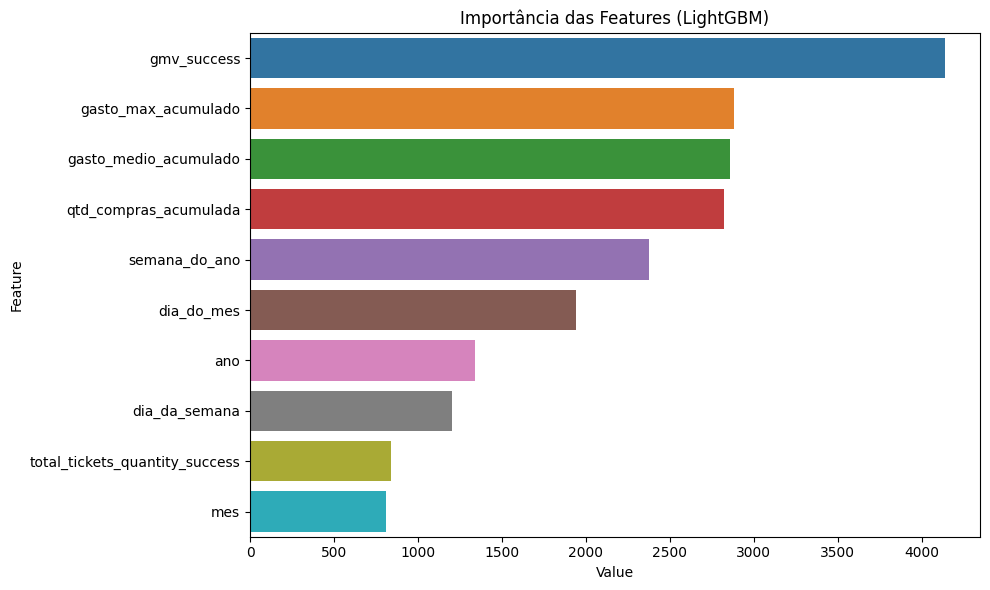

In [ ]:
# Cria um DataFrame com a importância de cada feature
feature_imp = pd.DataFrame(sorted(zip(lgb_clf.feature_importances_, X.columns)), columns=['Value','Feature'])

# Plota o gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Importância das Features (LightGBM)')
plt.tight_layout()
plt.savefig('../report/feature_importance.png') # Salva a imagem
feature_imp.sort_values(by="Value", ascending=False)

## Modelo de treinamento (XGBM)

In [ ]:
# Cria o classificador XGBoost
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    early_stopping_rounds=100
)

# Agora o .fit() não tem mais o parâmetro que causava o erro
xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Faz predições no conjunto de validação
preds_xgb = xgb_clf.predict_proba(X_val)[:, 1]

# Avalia a performance
auc_score_xgb = roc_auc_score(y_val, preds_xgb)

print(f"Modelo XGBoost treinado com sucesso!")
print(f"Melhor iteração: {xgb_clf.best_iteration}")
print(f"AUC na validação (XGBoost): {auc_score_xgb:.4f}")
print(f"AUC na validação (LightGBM): {auc_score:.4f}") # 'auc_score' foi salvo da célula anterior

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\callback.py:386: UserWarning: [12:21:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Modelo XGBoost treinado com sucesso!
Melhor iteração: 538
AUC na validação (XGBoost): 0.7003
AUC na validação (LightGBM): 0.7002


#### XGBM Foi quem conseguiu a melhor pontuação, apesar da diferença mínima a diferença ainda existe. Agora vamos fazer o Extra do desafio, vamos utilizar a técnica de regressão do XGMBoost para prever quantos dias até a compra, com  a taxa de erro menor possível

## Modelo de Regressão (XGMreg)

### Vamos focar em clientes que recompram em até 180 dias para criar um modelo robusto.

In [ ]:
LIMITE_DIAS = 180
df_train_reg_filtrado = df_train[df_train['dias_ate_prox_compra'] <= LIMITE_DIAS].copy()

print(f"Dados originais de treino: {len(df_train)} transações")
print(f"Dados filtrados (recompras em até {LIMITE_DIAS} dias): {len(df_train_reg_filtrado)} transações")


Dados originais de treino: 757720 transações
Dados filtrados (recompras em até 180 dias): 666163 transações


#### Preparar e dividir os dados filtrados

In [ ]:
features_reg = [
    'gmv_success', 'total_tickets_quantity_success', 'dia_da_semana', 
    'dia_do_mes', 'mes', 'ano', 'semana_do_ano', 'gasto_medio_acumulado', 
    'qtd_compras_acumulada', 'gasto_max_acumulado'
]

#### Adicionamos a feature de ritmo que é crucial para a regressão

In [ ]:
df_train_reg_filtrado['dias_desde_ultima_compra'] = df_train_reg_filtrado.groupby('fk_contact')['datetime'].diff().dt.days.fillna(0)
features_reg.append('dias_desde_ultima_compra')

#### Criamos X e y a partir dos dados filtrados

In [ ]:
X_reg_filtrado = df_train_reg_filtrado[features_reg]
y_reg_filtrado = df_train_reg_filtrado['dias_ate_prox_compra']

#### Dividimos os dados filtrados para treino e validação

In [ ]:
X_train_reg_f, X_val_reg_f, y_train_reg_f, y_val_reg_f = train_test_split(
    X_reg_filtrado, y_reg_filtrado, 
    test_size=0.2,
    random_state=42
)

print(f"Dados preparados para o regressor especialista.")
print(f"Shape do X_train_reg_f: {X_train_reg_f.shape}")

Dados preparados para o regressor especialista.
Shape do X_train_reg_f: (532930, 11)


### Otimização do Regressor Especialista com Optuna

In [ ]:
def objective_reg_filtrado(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'n_estimators': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
        'n_jobs': -1,
        'early_stopping_rounds': 50
    }
    
    model = xgb.XGBRegressor(**params)
    
    # IMPORTANTE: Usando os novos dados filtrados (_f)
    model.fit(
        X_train_reg_f, y_train_reg_f,
        eval_set=[(X_val_reg_f, y_val_reg_f)],
        verbose=False
    )
    
    preds = model.predict(X_val_reg_f)
    mae = mean_absolute_error(y_val_reg_f, preds)
    return mae

# Cria um novo estudo para o modelo especialista
study_reg_filtrado = optuna.create_study(direction='minimize')

# Inicia a otimização
study_reg_filtrado.optimize(objective_reg_filtrado, n_trials=30) 

print('\nOtimização do regressor especialista finalizada!')
print('Melhor MAE encontrado:', study_reg_filtrado.best_value)
print('Melhores parâmetros:', study_reg_filtrado.best_params)

# Guarda os melhores parâmetros para o treinamento final
best_params_reg_f = study_reg_filtrado.best_params

[I 2025-08-19 13:47:52,148] A new study created in memory with name: no-name-793a8bb7-9388-44ac-aed2-85de215813c8
[I 2025-08-19 13:47:56,726] Trial 0 finished with value: 28.597360610961914 and parameters: {'learning_rate': 0.03653535382906932, 'max_depth': 10, 'subsample': 0.5275792426832215, 'colsample_bytree': 0.7425297559991744}. Best is trial 0 with value: 28.597360610961914.
[I 2025-08-19 13:47:58,536] Trial 1 finished with value: 28.666996002197266 and parameters: {'learning_rate': 0.19235892224928497, 'max_depth': 10, 'subsample': 0.6958975867149235, 'colsample_bytree': 0.5800033912422795}. Best is trial 0 with value: 28.597360610961914.
[I 2025-08-19 13:48:00,795] Trial 2 finished with value: 28.595563888549805 and parameters: {'learning_rate': 0.1126137808277943, 'max_depth': 7, 'subsample': 0.665151650812063, 'colsample_bytree': 0.6221439645312746}. Best is trial 2 with value: 28.595563888549805.
[I 2025-08-19 13:48:08,650] Trial 3 finished with value: 28.650859832763672 and


Otimização do regressor especialista finalizada!
Melhor MAE encontrado: 28.560638427734375
Melhores parâmetros: {'learning_rate': 0.010175753607409691, 'max_depth': 8, 'subsample': 0.8860655389097168, 'colsample_bytree': 0.8263059164775551}


In [ ]:
# Lista de limites de dias que queremos testar
limites_para_testar = [30, 60, 90, 120, 180, 270, 365]

# Dicionário para guardar os resultados
resultados_mae = {}

print("Iniciando experimento para encontrar o melhor LIMITE_DIAS...")

for limite in limites_para_testar:
    print(f"\n--- Testando com LIMITE_DIAS = {limite} ---")
    
    # 1. Filtra os dados com o limite da vez
    df_filtrado = df_train[df_train['dias_ate_prox_compra'] <= limite].copy()
    
    # 2. Prepara X e y
    X_teste = df_filtrado[features_reg] # features_reg já deve existir de uma célula anterior
    y_teste = df_filtrado['dias_ate_prox_compra']
    
    # 3. Divide os dados
    X_train_t, X_val_t, y_train_t, y_val_t = train_test_split(
        X_teste, y_teste, test_size=0.2, random_state=42
    )
    
    # 4. Treina um modelo XGBRegressor (usando parâmetros padrão para ser rápido)
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        eval_metric='mae',
        n_estimators=1000,
        random_state=42,
        n_jobs=-1,
        early_stopping_rounds=30 # Parada antecipada mais agressiva para o teste
    )
    
    model.fit(X_train_t, y_train_t, eval_set=[(X_val_t, y_val_t)], verbose=False)
    
    # 5. Avalia e guarda o MAE
    preds = model.predict(X_val_t)
    mae = mean_absolute_error(y_val_t, preds)
    resultados_mae[limite] = mae
    
    print(f"MAE encontrado: {mae:.2f} dias para {len(df_filtrado)} amostras.")

# Converte os resultados para um DataFrame para fácil visualização
df_resultados = pd.DataFrame(list(resultados_mae.items()), columns=['Limite_Dias', 'MAE'])

print("\n--- Resultados Finais ---")
display(df_resultados.sort_values(by='MAE'))

# Plota o resultado para encontrar o "ponto ideal"
df_resultados.set_index('Limite_Dias')['MAE'].plot(
    kind='line', 
    marker='o', 
    grid=True,
    figsize=(10, 6),
    title='Performance do Modelo vs. Limite de Dias para Treino'
)
plt.xlabel('Limite de Dias Usado no Treino')
plt.ylabel('MAE (Erro Médio Absoluto) na Validação')
plt.show()


Iniciando experimento para encontrar o melhor LIMITE_DIAS...

--- Testando com LIMITE_DIAS = 30 ---


KeyError: "['dias_desde_ultima_compra'] not in index"